# Names and group number

ML_HMI_01: Jan Ubbo van Baardewijk & Thomas Brus

# Linear Discriminants: logistic regression

$\newcommand{\x}{\mathbf{x}}\newcommand{\w}{\mathbf{w}}\newcommand{\c}{\mathcal{C}}$

As we have seen in the lecture, the logistic regression models the probability of a class label $\c$ given a datapoint $p(\c|\x)$ as:
$$p(\c|\x) = \sigma(\w^\top\x) = \frac{1}{1+e^{-\w^\top\x}}$$

In this lab, we shall implement this model.

## Logistic function

To get started, let us plot the logistic function $\sigma(a)$ in the range $[-5\dots 5]$ in blue, and its derivative $\frac{\partial}{\partial a} \sigma(a)$ in green.

In [19]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt

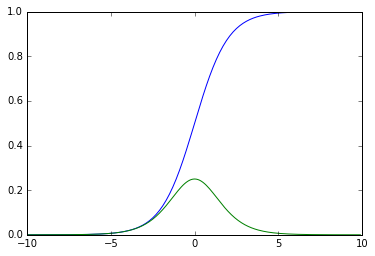

In [20]:
x = np.arange(-10, 10, .1)

def sigma(a):
    return 1.0 / (1.0 + np.exp(-a))

plt.plot(x, sigma(x))
plt.plot(x, sigma(x) * (1 - sigma(x)), 'green')

## Training data

Next, load the data in the provided data file "*data-2class.npz*", and plot it. Then also plot the discriminant of a logistic regression model with parameters $\w = [ 0,1,1]$.


$\frac{1}{1+e^{\w^\top\x}} = 1/2$, so $\exp \w^\top \x = 1$ or $\w^\top\x = 0$. In other words, we can plot 
$w_0+w_1x_1 + w_2x_2 = 0$, or $x_1 = -\frac{w_2x_2+w_0}{w_1}$

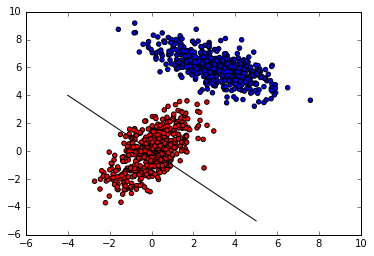

In [21]:
data = np.load("data-2class.npz")
d = data['d']
l = data['l']

colours = [['r', 'b'][int(x)] for x in np.nditer(l)]
plt.scatter(d[:, 0], d[:, 1], 20, colours)

def plotDisc(w):
    if abs(w[1]) > abs(w[2]):
        yr = np.arange(-6, 10, 1)
        xr = -(w[2] * yr + w[0]) / w[1]
        valid  = (xr > -4) & (xr < 10)
        plt.plot(xr[valid], yr[valid], 'k')
    else:
        xr = np.arange(-4, 10, 1)
        yr = -(w[1] * xr + w[0]) / w[2]
        valid  = (yr > -6) & (yr <10)
        plt.plot(xr[valid], yr[valid], 'k')

plotDisc([0, 1., 1.])

# # Probability of the given labels for all datapoints

We will now train our logistic regression model on a training dataset. This dataset contains a number of datapoints $\x_1,\dots,\x_N$belonging to two classes and, for each datapoint $\x_n$, the corresponding class label $l_n$. The training is done by *maximum likelihood*, that is, we maximise the probability of the data given the model. 

## Model

Before we start coding, let's have a closer look at the model. Our labels are $0$ or $1$, representing the two classes. If a datapoint $\x_n$ belongs to class $\c_n=1$, the probability $p(\c_n=1|\x_n) = \sigma(\w^\top\x_n)$ and the probability $p(\c_n=0|\x_n) = 1-\sigma(\w^\top\x)$. We now want the probability of the labels given the data, for the complete training set: $p(\c_1,\dots,\c_N|\x_1,\dots,\x_N)$. Remember that the probability of the union of two independent events is $p(a,b)=p(a)\,p(b)$. Using the fact that the labels are $0$ and $1$ (and that $x^0=1$ and $x^1=x$, we can then write this as 
$$p(\c_1\dots\c_n|\x_1\dots\x_n,\w) = \prod_{n=1}^N \sigma(\w^\top\x_n)^{\c_n}\,(1-\sigma(\w^\top\x_n))^{1-\c_n}$$

**Question [5 Marks]:** For the provided dataset, compute this probability when the model weights are $\w = [ 0,-1,-1]$
Think about how you could find the maximum of this function. What does the gradient of this probability look like?

In [22]:
prob = 1.0
w = np.matrix([[0, -1, -1]])

# Extend the data with a 1 in column 0
v = np.ones((d.shape[0], d.shape[1] + 1))
v[:, 1:] = d

for x, c in zip(v, l):
    s = sigma(sum([a * b for a,b in zip(w.flat, x)]))
    prob *= s**c[0] * (1 - s)**(1 - c[0])
    
print "Probability is (pretty much zero): ", prob
print "The maximum of the function is where the gradient is zero."
print "The gradient looks like the one plotted in the graph above,"
print "but depending on the class it may be inverted vertically."

Probability is (pretty much zero):  0.0
The maximum of the function is where the gradient is zero.
The gradient looks like the one plotted in the graph above,
but depending on the class it may be inverted vertically.


Dealing with the joint probability is complicated, as 1) its value can become very small, easily too small for a computer to represent it accurately, and 2) taking the gradient of this joint probability with respect to $\w$ makes the contribution of every datapoint to the gradient depend on every other datapoint's value.

# Gradient

So instead, we will define an error function which is the natural logarithm of the likelihood.

**Question [5 marks]:** Write down the equation for $E(\w) \triangleq -\log p(\c_1,\dots,\c_N|\x_1,\dots,\x_N)$ in analytical form.

$$E(\w) \triangleq - \sum_{n=1}^N \{ C_n \log(\sigma(\w^\top\x_n)) + (1 - C_n) \log(1 - \sigma(\w^\top\x_n)) \}$$

**Question [5 marks]:** Compute the actual value of the error function for the given dataset and weight $w=[0,-1,-1]$.

Notice that this function does not contain products of probabilities anymore, thus making the derivative of the joint probability with respect of each of the weights a sum of derivatives of the probabilities of single datapoints. The logarithm is what's called a "monotonically increasing function", which means that if $x_1 > x_2$, $f(x_1) > f(x_2)$. Because of that, the value of $\w$ for which $p(\c_1\dots\c_n|\x_1\dots\x_n,\w)$ is maximal is also the value of $\w$ for which $\log p(\c_1\dots\c_n|\x_1\dots\x_n,\w)$ is maximal and thus $-\log p(\c_1\dots\c_n|\x_1\dots\x_n,\w)$ is minimal.

The gradient of $\nabla_\w E(\w)$ is given by $\nabla_\w E(\w) = \sum_{n=1}^N \left(\sigma( \w^\top\x_n)-c_n\right)\x_n$

**Question [30 marks]:** Implement gradient descent, updating the weights as $\w^{\mathrm{new}} = \w^{\mathrm{old}} - \eta \nabla_\w E(\w)$. The value of $\eta$ will affect how fast the algorithm converges and is really up to you. In this case, I suggest you use $\eta=10^{-3}$, which is quite small but allows you to see what's happening. This is a form of batch gradient descent.

5056.86191856


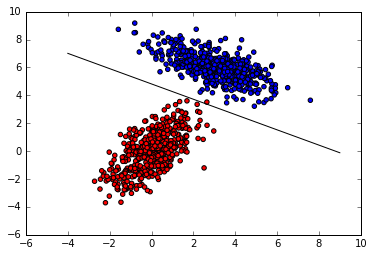

In [74]:
# Question [5 marks]
from math import log

logError = 0

for x, c in zip(v, l):
    s = sigma(sum([a * b for a,b in zip(w.flat, x)]))
    logError += c[0] * log(s) + (1 - c[0]) * log(1 - s)

print -logError
    
def calculate_error_gradient(data, weights):    
    d = data['d']
    l = data['l']
    
    # Extend the data with a 1 in column 0
    v = np.ones((d.shape[0], d.shape[1] + 1))
    v[:, 1:] = d
    
    #print v
    
    error_gradient = 0
    
    w = np.matrix(weights)

    for x, c in zip(v, l):
        s = sigma(sum([a * b for a,b in zip(w.flat, x)]))
        error_gradient += (s - c[0]) * x
    
    return error_gradient

def update_weights(weights, error_gradient=0, learning_rate=0.001):
    for i, weight in enumerate(weights):
        weights[i] = weight - learning_rate * error_gradient[i]

def gradient_descent(data, learning_rate=0.001, threshold=0.1, max_iterations=5000):
    #weights = [0.0 for i in data['d']]
    weights = [0.0, 0.0, 0.0]
    count=0
    while count < max_iterations:
        error_gradient = calculate_error_gradient(data, weights=weights)
        #if all(i < threshold for i in error_gradient): break
        update_weights(weights, error_gradient=error_gradient, learning_rate=learning_rate)
        count += 1
    
    return weights

colours = [['r', 'b'][int(x)] for x in np.nditer(l)]
plt.scatter(d[:, 0], d[:, 1], 20, colours)

def plotDisc(w):
    if abs(w[1]) > abs(w[2]):
        yr = np.arange(-6, 10, 1)
        xr = -(w[2] * yr + w[0]) / w[1]
        valid  = (xr > -4) & (xr < 10)
        plt.plot(xr[valid], yr[valid], 'k')
    else:
        xr = np.arange(-4, 10, 1)
        yr = -(w[1] * xr + w[0]) / w[2]
        valid  = (yr > -6) & (yr <10)
        plt.plot(xr[valid], yr[valid], 'k')
        
data = np.load("data-2class.npz")
#print calculate_error_gradient(data, [0.1, 0.1, 0.1])
weights = gradient_descent(data)
plotDisc(weights)

# Visualising the classifier

It is important to realise that the classifier must be able to compute the probability of a label for any new datapoint, independently of whether it was in the training data or not. We can, therefore, plot what the probability of class $\c_0$ is at any location in the input space. 

**Question [10 marks]:** Create a function that plots the data in a 3D graph in the plane $z=1/2$ and superimpose a wireframe of the probability of $\c_0$. Then adapt your code in the previous question to call this function.

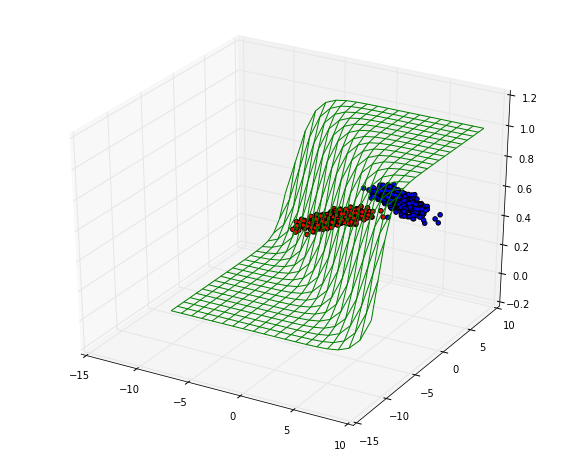

In [90]:
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D

import pylab
pylab.rcParams['figure.figsize'] = (10.0, 8.0)

fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

data = np.load("data-2class.npz")

d = data['d']
l = data['l'].sum(-1)

xs = d[:,0]
ys = d[:,1]

# 3d scatter plot
colors = [['r', 'b'][int(x)] for x in np.nditer(l)] 
ax.scatter(xs, ys, zs=0.5, zdir='z', s=20, c=colors, depthshade=False)

# 3d wireframe plot
x1 = np.arange(-10.0, 10.0, 1.0)
y1 = np.arange(-10.0, 10.0, 1.0)

X1, Y1 = np.meshgrid(x1, y1)

def z(x, y):
    return 1 - sigma(sum([a * b for a, b in zip([0, -1, -1], [1, x, y])]))

Z1 = z(X1, Y1)

ax.plot_wireframe(X1, Y1, Z1, colors='green')

# Stochastic gradient descent

**Question [20 marks]:** As a last question, implement stochastic gradient descent and compare it to batch gradient descent.